In [41]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import colorsys
import textwrap
import os
import json

def get_tiled_texture(texture_path, width, height):
    img = Image.new( 'RGB', (width,height), "black")
    pixels = img.load()
    texture = Image.open(texture_path)
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[i,j] = texture.getpixel((i%texture.width, j%texture.height))
    return img

def apply_image_to_background(img, image_path, pad_left=20, pad_top=50, truncate_height=None):
    x = pad_left
    y = pad_top
    pixels = img.load()
    image = Image.open(image_path)
    ow,oh = image.width, image.height
    nw = int(img.size[0]-pad_left*2)
    nh = int(nw * oh / ow)
    image = image.resize((nw, nh))
    
    for j in range(min(image.height, img.size[1]-pad_top)):
        for i in range(min(image.width, img.size[0]-pad_left)):
            pixels[i+pad_left, j+pad_top] = image.getpixel((i, j))
            if truncate_height is not None and j > truncate_height:
                return img # stop early
    return img

def scale_lightness(rgb, scale_l):
    h, l, s = colorsys.rgb_to_hls(*[x/255 for x in rgb])
    return tuple([int(x*255) for x in colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)])

def draw_borders(img, pad_left=10, pad_top=10, color=(210, 180, 140)):
    draw = ImageDraw.Draw(img)
    y = pad_top
    top_rect_height = 450
    bottom_rect_height = 250
    draw.rounded_rectangle((pad_left, y, img.width-pad_left, top_rect_height), fill=None, outline=color,
                           width=50, radius=10)
    y += top_rect_height + pad_top
    draw.rounded_rectangle((pad_left, y, img.width-pad_left, y + bottom_rect_height), fill=color, outline=color,
                           width=10, radius=10)
    y += bottom_rect_height - pad_top
    pill_width = 100
    pill_height = 50
    pill_color = scale_lightness(color, 1.5)
    draw.rounded_rectangle((pad_left + pad_left/2, y, pill_width+pad_left+pad_left/2, y+pill_height), fill=pill_color, outline=pill_color,
                           width=10, radius=10)
    draw.rounded_rectangle((img.width-(pad_left+pill_width+pad_left/2), y, img.width-pad_left-pad_left/2, y+pill_height), fill=pill_color, outline=pill_color,
                           width=10, radius=10)
    return img

def draw_text(img, color, card):
    draw = ImageDraw.Draw(img)
    title_fnt = ImageFont.truetype("./card_maker_assets/Blankenburg.ttf", 40)
    subtitle_fnt = ImageFont.truetype("./card_maker_assets/Blankenburg.ttf", 25)
    details_fnt = ImageFont.truetype("./card_maker_assets/Montserrat.ttf", 20)
    funfact_fnt = ImageFont.truetype("./card_maker_assets/Montserrat-Italic.ttf", 20)
    pill_fnt = ImageFont.truetype("./card_maker_assets/Blankenburg.ttf", 30)
    draw.text((20, 15), card['name'], fill=color, font=title_fnt)
    draw.text((25, 420), card['type'], fill=color, font=subtitle_fnt)
    draw.multiline_text((30, 485), '\n'.join(textwrap.wrap(card['description'], width=50)), fill=color, stroke_fill=color, font=details_fnt, spacing=20, stroke_width=1)
    draw.line((25, 570, 585, 570), fill=color)
    draw.multiline_text((30, 580), '\n'.join(textwrap.wrap(card['fun-fact'], width=50)), fill=color, stroke_fill=color, font=funfact_fnt, spacing=20, stroke_width=1)
    draw.text((40, 720), str(card['cost']) + 'p', fill=color, font=pill_fnt)
    draw.text((525, 720), 'L' + str(card['level']), fill=color, font=pill_fnt)
    return img

def apply_alpha(img):
    alpha = ImageOps.invert(Image.open('./card_maker_assets/alpha.png').convert("RGB"))
    img = img.convert('RGBA')
    img.putalpha(alpha.getchannel('R'))
    return img

def render_card_to_png(c, width=600, height=800, root_texture_asset_path='./card_maker_assets/textures', show=True, save_path=None):
    texture_path = os.path.join(root_texture_asset_path, c['texture'])
    img = get_tiled_texture(texture_path, width, height)
    border_color = img.resize((1, 1)).getpixel((0, 0))
    font_color = (0, 0, 0) if sum([x*s for x, s in zip(border_color, [0.299, 0.587, 0.114])]) <= 0.5 else (255, 255, 255)
    img = draw_borders(img, color=border_color)
    img = apply_image_to_background(img, os.path.join('./card_maker_assets/images', c['image']), pad_top=60, truncate_height=350)
    img = draw_text(img, font_color, c)
    img = apply_alpha(img)
    # TODO: Add reward if present
    # TODO: Add multi-target icon if present
    if show:
        img.show()
    if save_path is not None:
        img.save(save_path)

def render_all_cards(card_data_path='./card_maker_assets/data', output_path='../assets/images'):
    card_paths = os.listdir(card_data_path)
    for card_path in card_paths:
        with open(os.path.join(card_data_path, card_path), 'r') as fp:
            card = json.load(fp)
            render_card_to_png(card, show=True, save_path=os.path.join(output_path, card['output_name']))

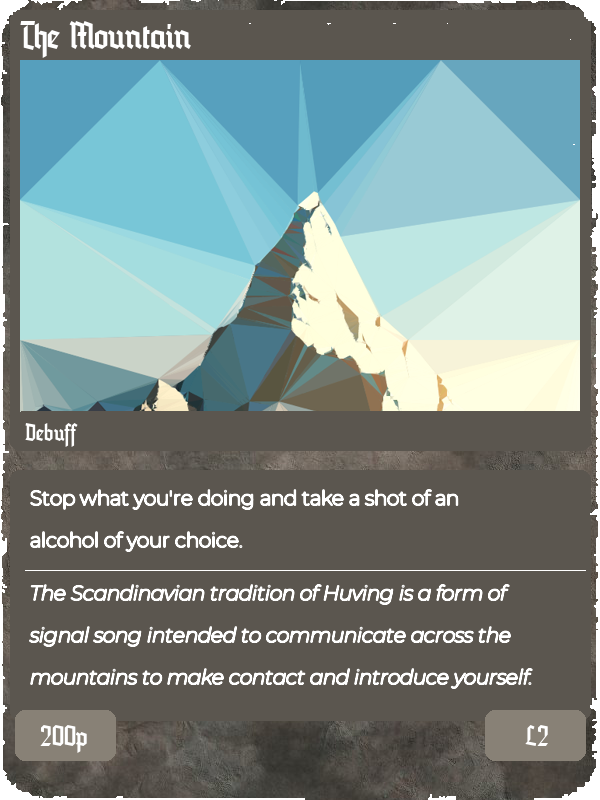

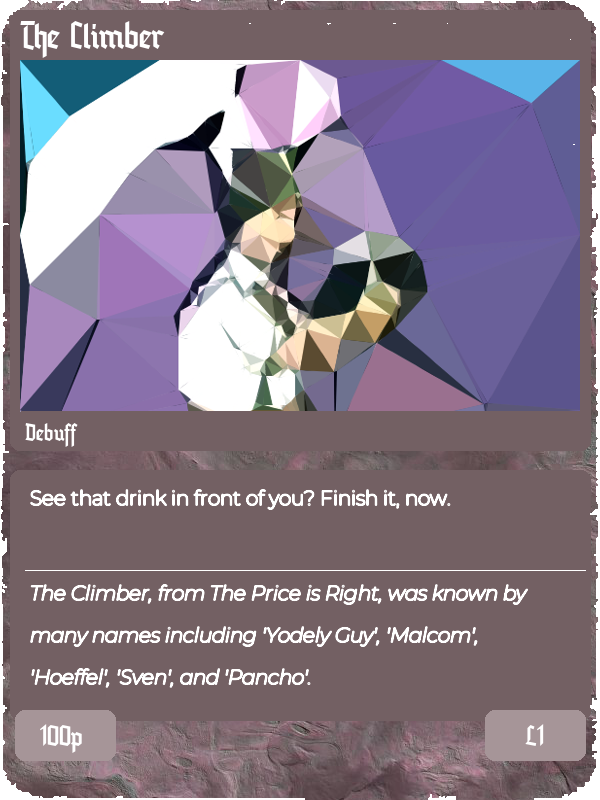

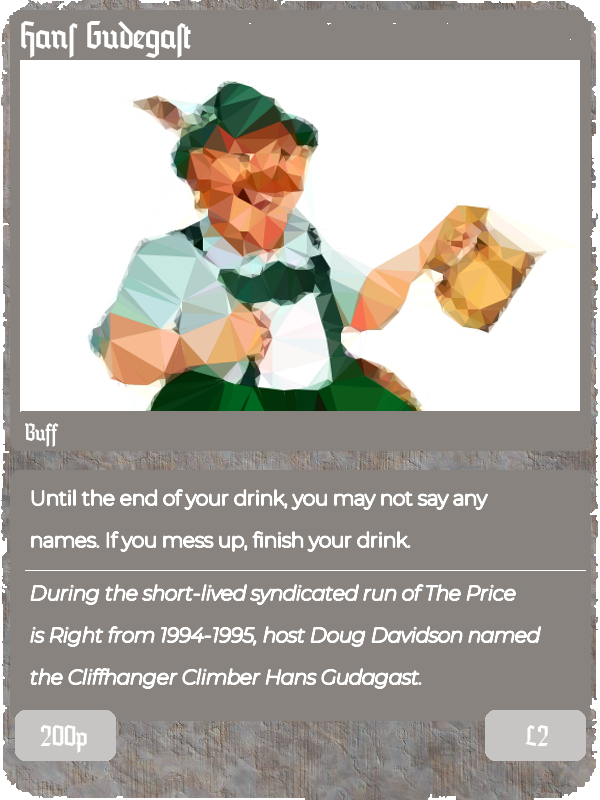

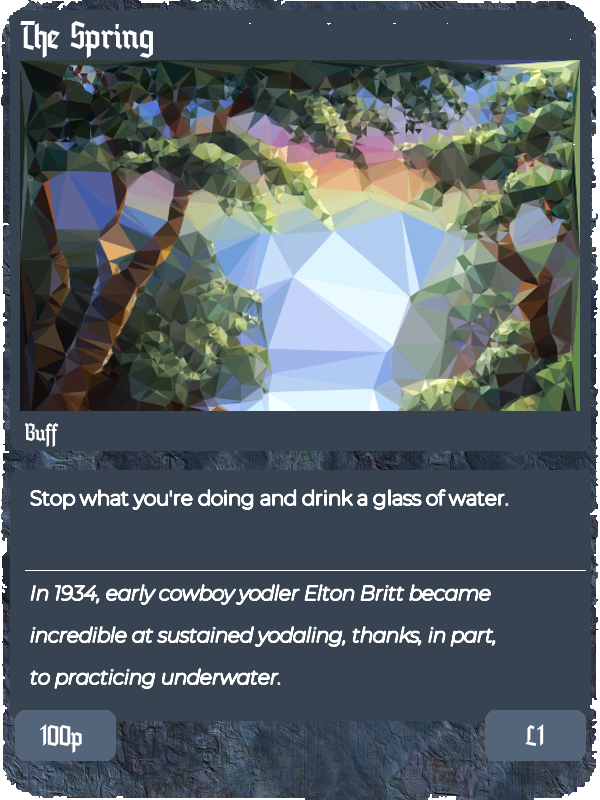

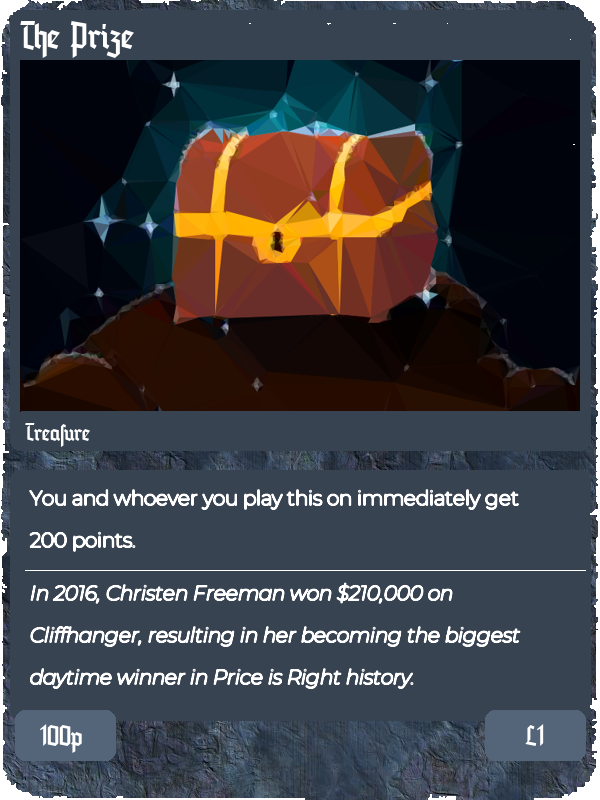

In [50]:
render_all_cards()